In [1]:
# import pertinent modules
import numpy as np
import pandas as pd
import time
from datetime import datetime
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import data previously saved from data wrangling exercise
df_import = pd.read_csv(r'C:\Users\Nikki\Temp\df.txt', sep = "|") 

#Google Drive Link
#https://drive.google.com/file/d/1SLtZIyWOzeRoI4onftNqkPq8pQMuinmX/view?usp=sharing

In [3]:
# Deterimine number of records in DataFrame
len(df_import)

12965819

In [4]:
# Review DataFrame info
df_import.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12965819 entries, 0 to 12965818
Data columns (total 55 columns):
Loan_ID                                12965819 non-null int64
Orig_Channel                           12965819 non-null object
Seller_Name                            12965819 non-null object
Orig_Int_Rate                          12965819 non-null float64
Orig_UPB                               12965819 non-null int64
Orig_Loan_Term                         12965819 non-null int64
Origination_Date                       12965819 non-null object
First_Pmt_Date                         12965819 non-null object
Orig_LTV                               12965819 non-null int64
Orig_CLTV                              12965694 non-null float64
Num_Borrowers                          12965819 non-null float64
Orig_Debt_Inc_Ratio                    12708039 non-null float64
Borrower_Credit_Score                  12965819 non-null float64
First_Time_Home_Buyer_Ind              12965819 non-

In [19]:
# Determine the number accounts that are currently open and those that are closed along with reason code for closure

# Total number of accounts
no_loans = len(df_import['Loan_ID'].value_counts())
# Number of closed accounts
df_closed = pd.DataFrame()
df_closed = copy.deepcopy(df_import[df_import['Zero_Balance_Code'].notna()])
no_closed = len(df_closed)
# Number of open accounts
no_open = no_loans - no_closed
print('There are ' + str(no_closed) + ' closed accounts and ' + str(no_open) + ' open accounts.')


There are 292705 closed accounts and 22291 open accounts.


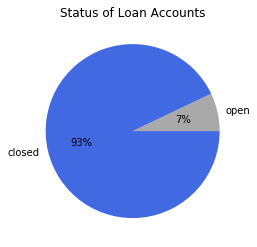

In [6]:
# Plot the number of open and closed accounts
x = [no_open, no_closed]
labels = ['open', 'closed']
colors = ['darkgrey', 'royalblue']
plt.pie(x, colors=colors, labels=labels, autopct='%1.0f%%')
plt.title('Status of Loan Accounts')

plt.show()

In [7]:
# Group by and count number of borrowers and store in dictionary
status = df_import['Zero_Balance_Code'].value_counts().to_dict()
print(status)

{1.0: 279993, 9.0: 7022, 3.0: 2073, 6.0: 1879, 16.0: 635, 2.0: 602, 15.0: 501}


In [8]:
# Save Zero Balance Codes to a list for future use in bar chart
order = list(status.keys())
print(order)

[1.0, 9.0, 3.0, 6.0, 16.0, 2.0, 15.0]


In [9]:
# Reassign Zero Balance Codes to descriptive identifiers
status['prepaid'] = status.pop(1.0)
status['3rd party sale'] = status.pop(2.0)
status['short sale'] = status.pop(3.0)
status['repurchased'] = status.pop(6.0)
status['REO'] = status.pop(9.0)
status['note sale'] = status.pop(15.0)
status['reperformance'] = status.pop(16.0)

# Check reassigned keys in dictionary
status

{'prepaid': 279993,
 '3rd party sale': 602,
 'short sale': 2073,
 'repurchased': 1879,
 'REO': 7022,
 'note sale': 501,
 'reperformance': 635}

In [10]:
# Sort dictionary by values in decreasing order, store keys in dictionary to be later used in boxplot
status_sorted = sorted(status.items(), key=lambda x: x[1])
ylabels = sorted(status.items(), key=lambda x: x[1], reverse=True)

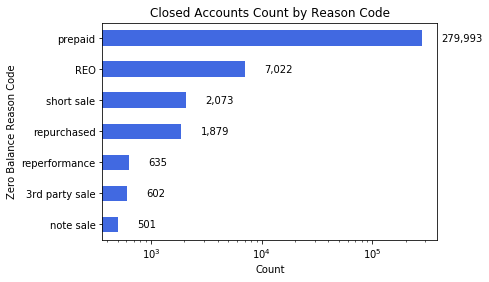

In [11]:
# Create a new DataFrame with Zero Balance Reason and counts from dictionary
column = pd.DataFrame(status_sorted, columns =['reason', 'count']) 
column.set_index('reason', inplace=True)
# Plot horizontal bar
column.plot(kind='barh', legend=False, color='royalblue')
plt.xscale('log')
plt.title('Closed Accounts Count by Reason Code')
plt.xlabel('Count')
plt.ylabel('Zero Balance Reason Code')
# Print count value at the end the horizontal bar
for i, (index, value) in enumerate(zip(column.index, column['count'])):
    plt.text(s='{0:,}'.format(value), x=value*1.5, y=i-.1)

plt.show()

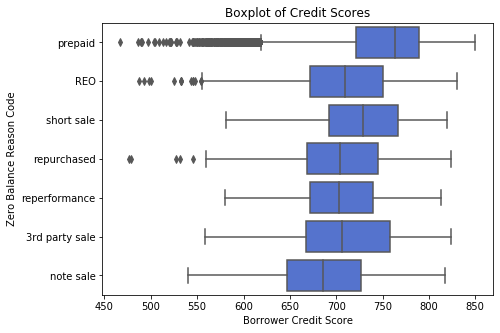

In [12]:
# Plot boxplot of Borrower Credit Scores 
plt.figure(figsize=(7,5))
ax = sns.boxplot(x="Borrower_Credit_Score", y="Zero_Balance_Code", data=df_import, color='royalblue', orient='h',
                order=order)
ax.set_title("Boxplot of Credit Scores")
_ = ax.set_yticklabels([x[0] for x in ylabels])
_ = ax.set(xlabel='Borrower Credit Score', ylabel='Zero Balance Reason Code')

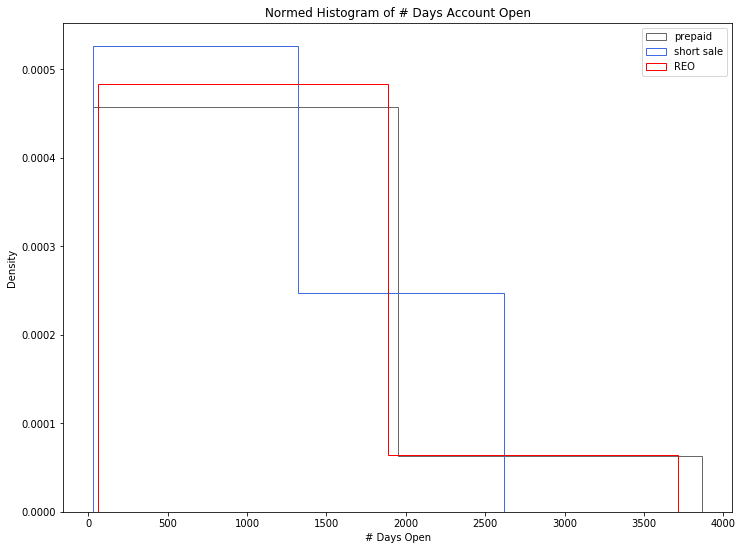

In [13]:
# Turn off errors related to NaN and/or divide by zero error
np.seterr(divide='ignore', invalid='ignore')

# Change datatypes to datetime
df_closed['Zero_Balance_Effective_Date'] = pd.to_datetime(df_closed['Zero_Balance_Effective_Date'],
                                                          format='%m/%Y')
df_closed['Origination_Date'] = pd.to_datetime(df_closed['Origination_Date'],
                                                          format='%m/%Y')
# Add new column to DataFrame that calculate the number of days each account was open
df_closed['Days_Open'] = pd.Series(delta.days for delta in df_closed['Zero_Balance_Effective_Date'] 
                                   - df_closed['Origination_Date'])
df_closed['Days_Open'].dropna()
#Create normed histograms for three of the Zero Balance Codes
plt.figure(figsize=(12,9))
plt.hist(df_closed['Days_Open'][df_closed['Zero_Balance_Code']==1], density=True, histtype='step', bins=2
         , color='dimgrey', label='prepaid')
plt.hist(df_closed['Days_Open'][df_closed['Zero_Balance_Code']==3], density=True, histtype='step', bins=2
         ,  color='royalblue', label='short sale')
plt.hist(df_closed['Days_Open'][df_closed['Zero_Balance_Code']==9], density=True, histtype='step', bins=2
         ,  color='red', label='REO')
plt.legend(loc='upper right')
plt.title('Normed Histogram of # Days Account Open')
plt.xlabel('# Days Open')
plt.ylabel('Density')

plt.show()                       

In [14]:
# Create DataFrame for each of three of the Zero Balance Codes
df_prepaid = df_closed[(df_closed['Zero_Balance_Code'] == 1)]
df_short = df_closed[(df_closed['Zero_Balance_Code'] == 3)]
df_reo = df_closed[(df_closed['Zero_Balance_Code'] == 9)]

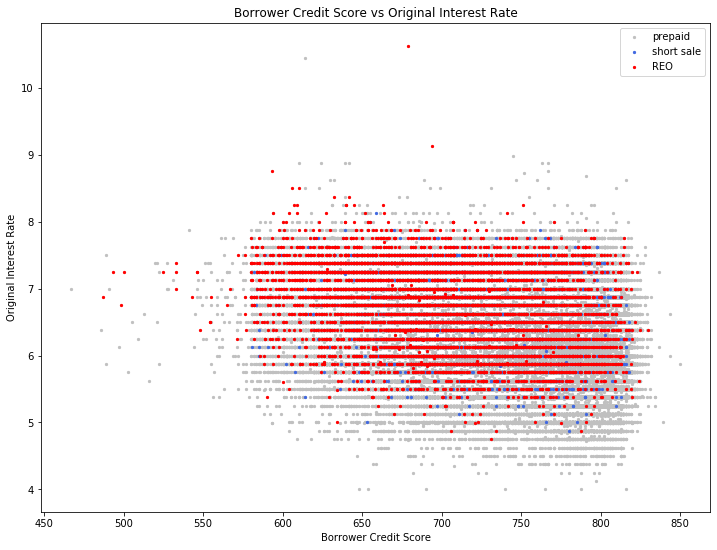

In [15]:
# Plot Borrower Credit Score and Original Interest Rate using a scatterplot
plt.figure(figsize=(12,9))
plt.scatter(x='Borrower_Credit_Score',y='Orig_Int_Rate'
            , data=df_prepaid, label='prepaid', color='silver', marker='.', s=20)
plt.scatter(x='Borrower_Credit_Score',y='Orig_Int_Rate'
            , data=df_short, label='short sale', color='royalblue', marker='.', s=20)
plt.scatter(x='Borrower_Credit_Score',y='Orig_Int_Rate'
            , data=df_reo, label='REO', color='red', marker='.', s=20)
plt.legend()
plt.title('Borrower Credit Score vs Original Interest Rate')
plt.xlabel('Borrower Credit Score')
plt.ylabel('Original Interest Rate')

plt.show()


In [16]:
# Create DataFrame of value count for each Reporting Period signifying the number of accounts active or open
df_active = pd.DataFrame(df_import['Reporting_Period'].value_counts())

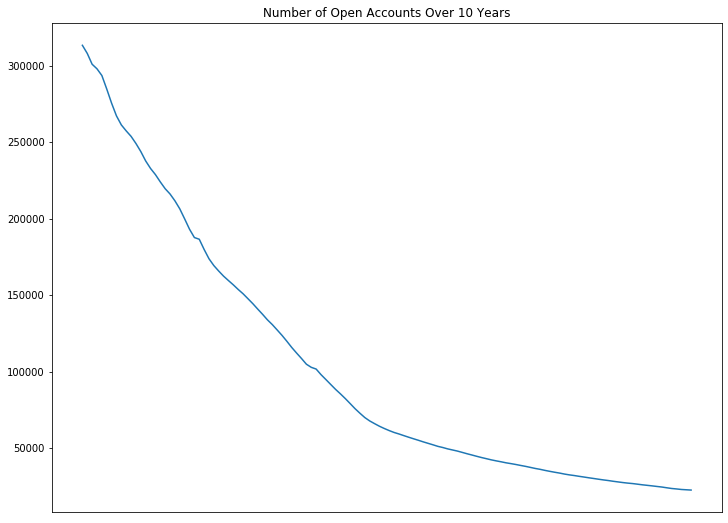

In [17]:
# Plot the number of accounts open over 10 year period
plt.figure(figsize=(12,9))
plt.plot(df_active['Reporting_Period'])
plt.xticks([])
plt.title('Number of Open Accounts Over 10 Years')
plt.show()

In [18]:
df_import['Reporting_Period'].value_counts()

2009-01-01    313434
2009-02-01    308123
2009-03-01    301042
2008-12-01    298047
2009-04-01    293663
2009-05-01    284858
2009-06-01    275556
2009-07-01    267249
2009-08-01    261349
2009-09-01    257435
2009-10-01    253865
2009-11-01    249193
2009-12-01    243911
2010-01-01    237774
2010-02-01    232862
2010-03-01    228853
2010-04-01    224077
2010-05-01    219627
2010-06-01    216170
2010-07-01    211719
2010-08-01    206460
2010-09-01    199898
2010-10-01    193141
2008-11-01    187691
2010-11-01    186584
2010-12-01    179897
2011-01-01    173803
2011-02-01    169334
2011-03-01    165760
2011-04-01    162421
               ...  
2016-10-01     34761
2016-11-01     34175
2016-12-01     33630
2017-01-01     32987
2017-02-01     32462
2017-03-01     32026
2017-04-01     31519
2017-05-01     31049
2017-06-01     30552
2017-07-01     30093
2017-08-01     29614
2017-09-01     29160
2017-10-01     28754
2017-11-01     28273
2017-12-01     27855
2018-01-01     27428
2018-02-01   

In [22]:
len(df_closed)

292705